# 1. Import the libraries 

In [3]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# 2. Load the dataset and add headers

In [5]:
# Import the dataset and give the column names
columns=['userId', 'productId', 'ratings','timestamp']
electronics_df=pd.read_csv('ratings_Beauty.csv',names=columns)

In [6]:
electronics_df.head()

,userId,productId,ratings,timestamp
0,UserId,ProductId,Rating,Timestamp
1,A39HTATAQ9V7YF,0205616461,5.0,1369699200
2,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
3,A1Z513UWSAAO0F,0558925278,5.0,1404691200
4,A1WMRR494NWEWV,0733001998,4.0,1382572800


#### Dropping the timestamp column

In [7]:
electronics_df.drop('timestamp',axis=1,inplace=True)

In [8]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023071 entries, 0 to 2023070
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   userId     object
 1   productId  object
 2   ratings    object
dtypes: object(3)
memory usage: 46.3+ MB


In [9]:
#Check the number of rows and columns
rows,columns=electronics_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  2023071
Number of columns:  3


In [10]:
#Check the datatypes
electronics_df.dtypes

userId       object
productId    object
ratings      object
dtype: object

In [20]:
#Taking subset of the dataset
electronics_df1=electronics_df.iloc[:100000,0:]
electronics_df1=electronics_df1.drop(index=0)

* Since the data is very big. Consider electronics_df1 named dataframe with  first 50000 rows and all columns from 0 of dataset.

In [21]:
electronics_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 1 to 99999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     99999 non-null  object
 1   productId  99999 non-null  object
 2   ratings    99999 non-null  object
dtypes: object(3)
memory usage: 3.1+ MB


In [22]:
#Summary statistics of rating variable
electronics_df1['ratings'].describe().transpose()

count     99999
unique        5
top         5.0
freq      63209
Name: ratings, dtype: object

In [17]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_df1.ratings.min()))
print('Maximum rating is: %d' %(electronics_df1.ratings.max()))

KeyError: '[0] not found in axis'

* Rating are on the scale 1 to 5.

# Handling Missing values

In [23]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_df.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
ratings      0
dtype: int64


* There are no missing records in the dataset.

## Ratings

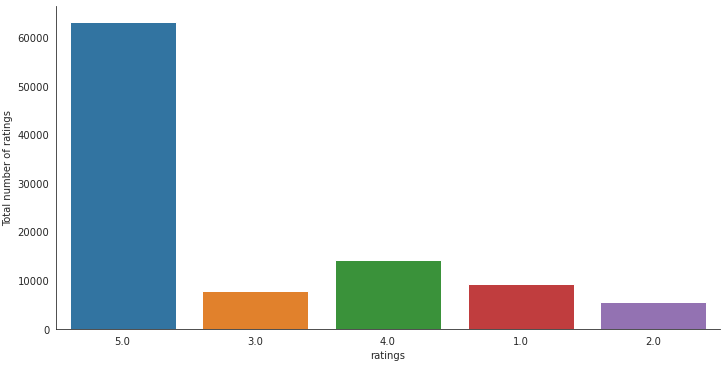

In [24]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("ratings", data=electronics_df1, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 

* We can see that more number of users have given the rating of 5.

## Users and products

In [25]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', electronics_df1['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', electronics_df1['productId'].nunique())

Number of unique users in Raw data =  91655
Number of unique product in Raw data =  6384


# 3. Taking the subset of dataset to make it less sparse/ denser.

In [26]:
#Check the top 10 users based on ratings
most_rated=electronics_df1.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
A281NPSIMI1C2R    79
A3M174IC0VXOS2    46
A1Z54EM24Y40LL    28
AKMEY1BSHSDG7     23
AK7CAW3N1XZV6     20
A132ETQPMHQ585    16
A223YFNSJ8X90C    16
AIIR8E34EDKCQ     15
A3KEZLJ59C1JVH    15
A2Y4S4CNGKF21S    15
dtype: int64


In [27]:
counts=electronics_df1.userId.value_counts()
electronics_df1_final=electronics_df1[electronics_df1.userId.isin(counts[counts>=15].index)]
print('Number of users who have rated 25 or more items =', len(electronics_df1_final))
print('Number of unique users in the final data = ', electronics_df1_final['userId'].nunique())
print('Number of unique products in the final data = ', electronics_df1_final['userId'].nunique())

Number of users who have rated 25 or more items = 273
Number of unique users in the final data =  10
Number of unique products in the final data =  10


* electronics_df1_final has the users who have rated 25 or more items.

## ratings analysis in final dataset

In [28]:
#constructing the pivot table
final_ratings_matrix = electronics_df1_final.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,9788073476,9788074421,B00000JGVX,B000050B6X,B000050FET,B000052WYD,B000052WYL,B000052XIA,B000052Y1Q,B000052Y33,...,B0002OCOQC,B0002OCOQM,B0002OCPAC,B0002OCPCA,B0002OCQVK,B0002RPTX4,B0002T54BY,B0002TG94U,B0002U476G,B0002VD4TG
userId,,,,,,,,,,,,,,,,,,,,,
A132ETQPMHQ585,0,0,0,0,0,0,0,5.0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1Z54EM24Y40LL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A223YFNSJ8X90C,0,0,0,0,0,0,0,0,0,0,...,5.0,5.0,5.0,5.0,5.0,0,0,0,0,0
A281NPSIMI1C2R,0,0,0,5.0,5.0,0,4.0,0,0,5.0,...,0,0,0,0,0,0,0,0,5.0,0
A2Y4S4CNGKF21S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* It shows that it is a sparse matrix. So, many cells are filled with 0 values.

In [29]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (10, 256)


* We can see that there are 7 products and 236 users.

In [30]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  273
possible_num_of_ratings =  2560
density: 10.66%


* The density value of the matrix also shows that it is a sparse matrix.

# 4. Splitting the data

In [31]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(electronics_df1_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,ratings
73127,A3M174IC0VXOS2,B00021AM9G,4.0
88675,A281NPSIMI1C2R,B00028PZUK,5.0
38027,A1Z54EM24Y40LL,B0000DAIOQ,5.0
93217,A2Y4S4CNGKF21S,B0002IKRMQ,1.0
10922,A3KEZLJ59C1JVH,B000052ZBH,5.0


In [32]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (191, 3)
Shape of testing data:  (82, 3)


# 5. Building Popularity Recommder model

In [33]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(40)

,productId,score
0,9788073476,1
1,9788074421,1
2,B00000JGVX,1
3,B000050B6X,1
4,B000050FET,1
5,B000052WYL,1
6,B000052Y33,1
7,B000052YJX,2
8,B000052YKU,1
9,B000052YM4,1


In [34]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productId,score,rank
135,B00021B8L2,3,1.0
141,B00021DVCQ,3,2.0
7,B000052YJX,2,3.0
30,B0000535U2,2,4.0
35,B0000536F0,2,5.0


In [35]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [36]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

The list of recommendations for the userId: 10

     userId   productId  score  rank
135      10  B00021B8L2      3   1.0
141      10  B00021DVCQ      3   2.0
7        10  B000052YJX      2   3.0
30       10  B0000535U2      2   4.0
35       10  B0000536F0      2   5.0


The list of recommendations for the userId: 100

     userId   productId  score  rank
135     100  B00021B8L2      3   1.0
141     100  B00021DVCQ      3   2.0
7       100  B000052YJX      2   3.0
30      100  B0000535U2      2   4.0
35      100  B0000536F0      2   5.0


The list of recommendations for the userId: 150

     userId   productId  score  rank
135     150  B00021B8L2      3   1.0
141     150  B00021DVCQ      3   2.0
7       150  B000052YJX      2   3.0
30      150  B0000535U2      2   4.0
35      150  B0000536F0      2   5.0




* Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.

# 6. Building Collaborative Filtering recommender model.

In [37]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,userId,productId,ratings
0,73127,A3M174IC0VXOS2,B00021AM9G,4.0
1,88675,A281NPSIMI1C2R,B00028PZUK,5.0
2,38027,A1Z54EM24Y40LL,B0000DAIOQ,5.0
3,93217,A2Y4S4CNGKF21S,B0002IKRMQ,1.0
4,10922,A3KEZLJ59C1JVH,B000052ZBH,5.0


## User Based Collaborative Filtering model

In [38]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = electronics_df_CF.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.head()

productId,9788073476,9788074421,B00000JGVX,B000050B6X,B000050FET,B000052WYD,B000052WYL,B000052XIA,B000052Y1Q,B000052Y33,...,B0002OCOQC,B0002OCOQM,B0002OCPAC,B0002OCPCA,B0002OCQVK,B0002RPTX4,B0002T54BY,B0002TG94U,B0002U476G,B0002VD4TG
userId,,,,,,,,,,,,,,,,,,,,,
A132ETQPMHQ585,0,0,0,0,0,0,0,5.0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1Z54EM24Y40LL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A223YFNSJ8X90C,0,0,0,0,0,0,0,0,0,0,...,5.0,5.0,5.0,5.0,5.0,0,0,0,0,0
A281NPSIMI1C2R,0,0,0,5.0,5.0,0,4.0,0,0,5.0,...,0,0,0,0,0,0,0,0,5.0,0
A2Y4S4CNGKF21S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (10, 256)


In [40]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,9788073476,9788074421,B00000JGVX,B000050B6X,B000050FET,B000052WYD,B000052WYL,B000052XIA,B000052Y1Q,B000052Y33,...,B0002OCOQM,B0002OCPAC,B0002OCPCA,B0002OCQVK,B0002RPTX4,B0002T54BY,B0002TG94U,B0002U476G,B0002VD4TG,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A132ETQPMHQ585,0,0,0,0,0,0,0,5.0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1Z54EM24Y40LL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
A223YFNSJ8X90C,0,0,0,0,0,0,0,0,0,0,...,5.0,5.0,5.0,5.0,0,0,0,0,0,2
A281NPSIMI1C2R,0,0,0,5.0,5.0,0,4.0,0,0,5.0,...,0,0,0,0,0,0,0,5.0,0,3
A2Y4S4CNGKF21S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [41]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

productId,9788073476,9788074421,B00000JGVX,B000050B6X,B000050FET,B000052WYD,B000052WYL,B000052XIA,B000052Y1Q,B000052Y33,...,B0002OCOQC,B0002OCOQM,B0002OCPAC,B0002OCPCA,B0002OCQVK,B0002RPTX4,B0002T54BY,B0002TG94U,B0002U476G,B0002VD4TG
user_index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,5.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,5.0,5.0,5.0,5.0,5.0,0,0,0,0,0
3,0,0,0,5.0,5.0,0,4.0,0,0,5.0,...,0,0,0,0,0,0,0,0,5.0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* As this is a sparse matrix we will use SVD.

### Singular Value Decomposition

In [52]:
# Singular Value Decomposition
pivot_df=pivot_df.astype('float64')
U, sigma, Vt = svds(pivot_df,k=5)

In [53]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-1.10791911e-15  5.85542597e-03 -9.77662835e-05 -8.69945747e-04
   1.25511941e-02]
 [-3.95697965e-16  1.36673287e-03 -9.98656028e-01  5.17107567e-02
   2.11206567e-04]
 [ 1.00000000e+00 -2.55079757e-16 -4.42485185e-16 -1.77994687e-16
  -6.47174446e-17]
 [-1.05167945e-16  5.12361871e-02 -1.01298736e-03 -2.16332787e-02
   9.96820338e-01]
 [-1.21963808e-16 -8.54467978e-02  3.85384713e-06 -6.42036509e-05
   1.58394704e-02]
 [ 6.38732720e-16 -4.60818524e-02  2.19088900e-03  2.01223890e-02
   2.81667896e-02]
 [ 3.11113382e-16 -3.00643577e-03  5.15092978e-02  9.97492798e-01
   1.94367374e-02]
 [ 1.51715553e-15  2.36405476e-02  4.96400233e-03  3.79961541e-02
   4.77627541e-02]
 [-1.51517249e-15 -1.99870720e-03  7.58533071e-08 -5.20554913e-07
   3.99883834e-05]
 [-2.99274367e-16 -9.93650893e-01 -1.56611083e-03 -4.09123961e-03
   4.98829795e-02]]


In [54]:
print('Sigma: \n',sigma)

Sigma: 
 [20.         22.93477998 23.6268136  29.12641012 44.03870091]


* As sigma is not a diagonal matrix we have to convert it into diagonal matrix.

In [55]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[20.          0.          0.          0.          0.        ]
 [ 0.         22.93477998  0.          0.          0.        ]
 [ 0.          0.         23.6268136   0.          0.        ]
 [ 0.          0.          0.         29.12641012  0.        ]
 [ 0.          0.          0.          0.         44.03870091]]


In [56]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 1.59683180e-16  1.59683180e-16  6.22226765e-17 ...  7.77783456e-17
  -2.62919862e-17 -7.48185918e-17]
 [-1.00462818e-02 -1.00462818e-02 -5.24345256e-04 ... -6.55431571e-04
   1.11699757e-02 -2.16625338e-01]
 [ 4.63644620e-04  4.63644620e-04  8.72048152e-03 ...  1.09006019e-02
  -2.14372403e-04 -3.31426585e-04]
 [ 3.45432014e-03  3.45432014e-03  1.36988087e-01 ...  1.71235108e-01
  -3.71368779e-03 -7.02324727e-04]
 [ 3.19795873e-03  3.19795873e-03  1.76542332e-03 ...  2.20677915e-03
   1.13175493e-01  5.66353894e-03]]


In [57]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,9788073476,9788074421,B00000JGVX,B000050B6X,B000050FET,B000052WYD,B000052WYL,B000052XIA,B000052Y1Q,B000052Y33,...,B0002OCOQC,B0002OCOQM,B0002OCPAC,B0002OCPCA,B0002OCQVK,B0002RPTX4,B0002T54BY,B0002TG94U,B0002U476G,B0002VD4TG
0,3.298919e-04,3.298919e-04,-2.585801e-03,6.415107e-02,6.415107e-02,-5.188446e-03,5.132086e-02,9.629242e-04,-5.600467e-05,6.415107e-02,...,-5.550134e-15,-5.550134e-15,-5.550134e-15,-5.550134e-15,-5.550134e-15,-2.594223e-02,3.521826e-03,-3.232251e-03,6.415107e-02,-2.594223e-02
1,-6.022166e-03,-6.022166e-03,5.641310e-04,8.675695e-04,8.675695e-04,4.925204e-06,6.940556e-04,3.165152e-04,-1.412961e-05,8.675695e-04,...,1.831300e-16,1.831300e-16,1.831300e-16,1.831300e-16,1.831300e-16,2.462602e-05,-1.475061e-02,7.051638e-04,8.675695e-04,2.462602e-05
2,3.220566e-15,3.220566e-15,4.411274e-16,-8.922504e-16,-8.922504e-16,-4.762124e-17,-7.138003e-16,-5.550134e-15,-7.573326e-15,-8.922504e-16,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,-2.381062e-16,7.495373e-15,5.514092e-16,-8.922504e-16,-2.381062e-16
3,1.263932e-01,1.263932e-01,-9.641285e-03,4.983725e+00,4.983725e+00,-1.096421e-03,3.986980e+00,6.415107e-02,-3.126686e-04,4.983725e+00,...,-8.922504e-16,-8.922504e-16,-8.922504e-16,-8.922504e-16,-8.922504e-16,-5.482106e-03,2.399756e-01,-1.205161e-02,4.983725e+00,-5.482106e-03
4,2.191205e-02,2.191205e-02,2.003655e-03,5.706262e-02,5.706262e-02,8.569466e-02,4.565009e-02,-1.507338e-03,8.570828e-04,5.706262e-02,...,-5.059171e-16,-5.059171e-16,-5.059171e-16,-5.059171e-16,-5.059171e-16,4.284733e-01,-6.329464e-03,2.504569e-03,5.706262e-02,4.284733e-01


In [58]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [59]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)    


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B00021W26M                  0.0          0.239976
B00005NASR                  0.0          0.239976
B00012NKGS                  0.0          0.239976
B0000AZVZQ                  0.0          0.239976
B0000ZLEFU                  0.0          0.239976


In [60]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
B0000536F0                  0.0          0.361936
B00012NEYG                  0.0          0.361936
B0000A4EW3                  0.0          0.336657
B0002RPTX4                  0.0          0.235543
B00021VZNS                  0.0          0.235543


In [61]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
B0000535U2                  0.0          0.396031
B00021DUM2                  0.0          0.245132
B0000C4COV                  0.0          0.239976
B00014DSE0                  0.0          0.239976
B00028PZUK                  0.0          0.239976


* Since, it is a Collaborative recommender model, so, all the three users are given different recommendations based on users past behaviour.

# 7. Evaluation of Collabrative recommendation model 

In [62]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,9788073476,9788074421,B00000JGVX,B000050B6X,B000050FET,B000052WYD,B000052WYL,B000052XIA,B000052Y1Q,B000052Y33,...,B0002OCOQC,B0002OCOQM,B0002OCPAC,B0002OCPCA,B0002OCQVK,B0002RPTX4,B0002T54BY,B0002TG94U,B0002U476G,B0002VD4TG
userId,,,,,,,,,,,,,,,,,,,,,
A132ETQPMHQ585,0,0,0,0,0,0,0,5.0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1Z54EM24Y40LL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A223YFNSJ8X90C,0,0,0,0,0,0,0,0,0,0,...,5.0,5.0,5.0,5.0,5.0,0,0,0,0,0
A281NPSIMI1C2R,0,0,0,5.0,5.0,0,4.0,0,0,5.0,...,0,0,0,0,0,0,0,0,5.0,0
A2Y4S4CNGKF21S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

Series([], dtype: float64)

In [64]:
# Predicted ratings 
preds_df.head()

productId,9788073476,9788074421,B00000JGVX,B000050B6X,B000050FET,B000052WYD,B000052WYL,B000052XIA,B000052Y1Q,B000052Y33,...,B0002OCOQC,B0002OCOQM,B0002OCPAC,B0002OCPCA,B0002OCQVK,B0002RPTX4,B0002T54BY,B0002TG94U,B0002U476G,B0002VD4TG
0,3.298919e-04,3.298919e-04,-2.585801e-03,6.415107e-02,6.415107e-02,-5.188446e-03,5.132086e-02,9.629242e-04,-5.600467e-05,6.415107e-02,...,-5.550134e-15,-5.550134e-15,-5.550134e-15,-5.550134e-15,-5.550134e-15,-2.594223e-02,3.521826e-03,-3.232251e-03,6.415107e-02,-2.594223e-02
1,-6.022166e-03,-6.022166e-03,5.641310e-04,8.675695e-04,8.675695e-04,4.925204e-06,6.940556e-04,3.165152e-04,-1.412961e-05,8.675695e-04,...,1.831300e-16,1.831300e-16,1.831300e-16,1.831300e-16,1.831300e-16,2.462602e-05,-1.475061e-02,7.051638e-04,8.675695e-04,2.462602e-05
2,3.220566e-15,3.220566e-15,4.411274e-16,-8.922504e-16,-8.922504e-16,-4.762124e-17,-7.138003e-16,-5.550134e-15,-7.573326e-15,-8.922504e-16,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,-2.381062e-16,7.495373e-15,5.514092e-16,-8.922504e-16,-2.381062e-16
3,1.263932e-01,1.263932e-01,-9.641285e-03,4.983725e+00,4.983725e+00,-1.096421e-03,3.986980e+00,6.415107e-02,-3.126686e-04,4.983725e+00,...,-8.922504e-16,-8.922504e-16,-8.922504e-16,-8.922504e-16,-8.922504e-16,-5.482106e-03,2.399756e-01,-1.205161e-02,4.983725e+00,-5.482106e-03
4,2.191205e-02,2.191205e-02,2.003655e-03,5.706262e-02,5.706262e-02,8.569466e-02,4.565009e-02,-1.507338e-03,8.570828e-04,5.706262e-02,...,-5.059171e-16,-5.059171e-16,-5.059171e-16,-5.059171e-16,-5.059171e-16,4.284733e-01,-6.329464e-03,2.504569e-03,5.706262e-02,4.284733e-01


In [65]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
9788073476    0.050477
9788074421    0.050477
B00000JGVX    0.422121
B000050B6X    0.545433
B000050FET    0.545433
dtype: float64

In [66]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(256, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
9788073476,NaN,0.050477,0
9788074421,NaN,0.050477,1
B00000JGVX,NaN,0.422121,2
B000050B6X,NaN,0.545433,3
B000050FET,NaN,0.545433,4


In [67]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = nan 



# 8. Getting top - K ( K = 5) recommendations. 

In [68]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
B00021B8L2                  0.0          0.010984
B00008J2XQ                  0.0          0.009940
B00021VZNS                  0.0          0.009940
B0002EPS3S                  0.0          0.009940
B0002RPTX4                  0.0          0.009940


# Summarising insights.

* The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.We can see the differance above for the user id 4, 6 & 8, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.

* Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.